The only purpose of this notebook is to generate a submission.

In [1]:
LOCAL = True
data_fpath = '../data/raw/' if LOCAL else '/kaggle/input/protein-localization/'
data_eng_fpath = '../data/intermediate/' if LOCAL else '../input/data-engineering/'
out_fpath = '../data/intermediate/' if LOCAL else ''
model_fpath = '../results/models/' if LOCAL else ''
selected_feats_fpath = '../data/intermediate/' if LOCAL else '../input/lightgbm-feature-selection/'

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import data_tools

In [3]:
from datetime import datetime
import pickle

import lightgbm as lgb
import pandas as pd
import numpy as np

SEED = np.random.randint(10000)

In [4]:
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score


from imblearn.over_sampling import RandomOverSampler, SMOTENC

In [5]:
# Use the accuracy metric
def accuracy(y_true, y_pred):
    preds = y_pred.reshape(15, -1)
    preds = preds.argmax(axis = 0)
    return 'acc.', accuracy_score(y_true, preds), True

def balanced_accuracy(y_true, y_pred):
    preds = y_pred.reshape(15, -1)
    preds = preds.argmax(axis = 0)
    return 'bal. acc.', balanced_accuracy_score(y_true, preds), True

def f1_weighted(y_true, y_pred):
    preds = y_pred.reshape(15, -1)
    preds = preds.argmax(axis = 0)
    return 'f1', f1_score(y_true, preds, average='weighted'), True

def f1_macro(y_true, y_pred):
    preds = y_pred.reshape(15, -1)
    preds = preds.argmax(axis = 0)
    return 'f1', f1_score(y_true, preds, average='macro'), True

## Load Training DataFrame

In [6]:
X = pd.read_pickle(f"{data_eng_fpath}X_enc.pkl")
y = pd.read_pickle(f"{data_eng_fpath}y.pkl")
X.shape, y.shape

((862, 2041), (862,))

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 862 entries, 0 to 861
Columns: 2041 entries, 445 to strongest_localization_vacuole
dtypes: float64(64), int64(25), uint8(1952)
memory usage: 2.2 MB


## Load Competition Data
* Note that data engineering pipeline drops labels, so we'll need this

In [8]:
testdf = pd.read_csv(f"{data_fpath}test.csv", header=None)

## Feature Selection
* See feature selection notebook

In [9]:
with open(f'{selected_feats_fpath}important_feats.pkl', 'rb') as handle:
    important_feats = pickle.load(handle)

In [10]:
# X = X[important_feats]

## Split Data
* Because some classes literally have one training instance, first I duplicate those values so they can appear in test data (best we can do tbh)
* Then I upsample training data again, because we need this to satisfy SMOTE conditions
* Afterwards, I split to train/test, and then use SMOTE/ADASYN on minority classes

In [11]:
ros = RandomOverSampler(sampling_strategy={i : 2 for i in range(12, 15)})
X_upsampled, y_upsampled = ros.fit_resample(X, y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_upsampled, y_upsampled, test_size=0.2, stratify=y_upsampled)

X_train.shape, X_test.shape

((691, 2041), (173, 2041))

In [13]:
categoricals = X_train.select_dtypes(include=['category']).columns
categoricals_by_idx = [X_train.columns.get_loc(c) for c in categoricals]

### LightGBM

In [14]:
N_ESTIMATORS = 500  # default is 100
hyper_params = {
    'boosting_type': 'gbdt',
    'random_state' : SEED,
    'objective' : 'multiclass',
#     'zero_as_missing' : True,
    'metric' : 'None',

    'reg_alpha': 0,
    'reg_lambda' : 0,
    'num_leaves': 400,
    'max_depth' : 8,
    'colsample_bytree' : 0.8,
    'subsample' : 0.9,
    'min_child_samples': 5,
    'class_weight' : {
        1 : 1.3,
    },

    # Training Parameters
    'learning_rate' : 0.01,
    'n_estimators': N_ESTIMATORS,
#     'first_metric_only' : True,
}
# model = lgb.LGBMClassifier(**hyper_params)
model = lgb.LGBMClassifier()
model.set_params(**hyper_params)

LGBMClassifier(class_weight={1: 1.3}, colsample_bytree=0.8, learning_rate=0.01,
               max_depth=8, metric='None', min_child_samples=5,
               n_estimators=500, num_leaves=400, objective='multiclass',
               random_state=2842, reg_alpha=0, reg_lambda=0, subsample=0.9)

In [15]:
fit_params={
    "early_stopping_rounds": 100, 
    "eval_metric" : [
        accuracy,
#         'logloss',
        f1_macro,
#         balanced_accuracy,
    ],
    "eval_set" : [
        (X_train, y_train),
        (X_test, y_test),
    ],
    'eval_names': ['train', 'validation'],
    'verbose': N_ESTIMATORS // 10,
    
}
model.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 100 rounds
[50]	train's acc.: 0.858177	train's f1: 0.895403	validation's acc.: 0.65896	validation's f1: 0.408726
[100]	train's acc.: 0.936324	train's f1: 0.96433	validation's acc.: 0.676301	validation's f1: 0.394255
[150]	train's acc.: 0.959479	train's f1: 0.976089	validation's acc.: 0.67052	validation's f1: 0.400217
Early stopping, best iteration is:
[61]	train's acc.: 0.891462	train's f1: 0.922884	validation's acc.: 0.687861	validation's f1: 0.422229


LGBMClassifier(class_weight={1: 1.3}, colsample_bytree=0.8, learning_rate=0.01,
               max_depth=8, metric='None', min_child_samples=5,
               n_estimators=500, num_leaves=400, objective='multiclass',
               random_state=2842, reg_alpha=0, reg_lambda=0, subsample=0.9)

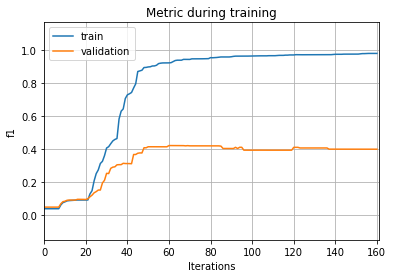

In [16]:
lgb.plot_metric(model);

In [17]:
y_pred = pd.Series(model.predict(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.96      0.82        73
           1       0.60      0.68      0.64        38
           2       0.55      0.43      0.48        14
           3       0.71      0.42      0.53        12
           4       1.00      0.22      0.36         9
           5       0.71      0.56      0.63         9
           6       1.00      0.29      0.44         7
           7       1.00      0.50      0.67         4
           8       1.00      0.33      0.50         3
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1

    accuracy                           0.69       173
   macro avg       0.61      0.37      0.42       173
weighted avg       0.70      0.69      0.66       173



# Full model fit

## Fit model on full dataset

In [18]:
hyper_params['n_estimators'] = 150
hyper_params['learning_rate'] = 0.01

full_model = lgb.LGBMClassifier()
full_model.set_params(**hyper_params)
full_fit_params={
    "early_stopping_rounds": 100, 
    "eval_metric" : [
        f1_macro,
        balanced_accuracy,
        accuracy
    ],
    "eval_set" : [(X, y)],
    'eval_names': ['train'],
    'verbose': hyper_params['n_estimators'] // 10,
    
}
full_model.fit(X, y, **full_fit_params)

Training until validation scores don't improve for 100 rounds
[15]	train's f1: 0.090007	train's bal. acc.: 0.103125	train's acc.: 0.546404
[30]	train's f1: 0.360858	train's bal. acc.: 0.293549	train's acc.: 0.689095
[45]	train's f1: 0.77544	train's bal. acc.: 0.704303	train's acc.: 0.824826
[60]	train's f1: 0.910205	train's bal. acc.: 0.870531	train's acc.: 0.882831
[75]	train's f1: 0.92784	train's bal. acc.: 0.898025	train's acc.: 0.902552
[90]	train's f1: 0.935139	train's bal. acc.: 0.90505	train's acc.: 0.910673
[105]	train's f1: 0.939973	train's bal. acc.: 0.912056	train's acc.: 0.919954
[120]	train's f1: 0.943131	train's bal. acc.: 0.917008	train's acc.: 0.924594
[135]	train's f1: 0.947918	train's bal. acc.: 0.925219	train's acc.: 0.930394
[150]	train's f1: 0.951246	train's bal. acc.: 0.929654	train's acc.: 0.939675
Did not meet early stopping. Best iteration is:
[149]	train's f1: 0.951517	train's bal. acc.: 0.930001	train's acc.: 0.940835


LGBMClassifier(class_weight={1: 1.3}, colsample_bytree=0.8, learning_rate=0.01,
               max_depth=8, metric='None', min_child_samples=5,
               n_estimators=150, num_leaves=400, objective='multiclass',
               random_state=2842, reg_alpha=0, reg_lambda=0, subsample=0.9)

# Competition Data

### Create Submission

In [19]:
X_kaggle = pd.read_pickle(f"{data_eng_fpath}X_kaggle.pkl")
X_kaggle.shape

(381, 539)

In [20]:
y_kaggle = pd.Series(full_model.predict(X_kaggle[important_feats]))
pd.concat((y_kaggle.value_counts().sort_index(), y_kaggle.value_counts().sort_index() / len(y_kaggle)), axis=1)

ValueError: Number of features of the model must match the input. Model n_features_ is 2041 and input n_features is 136 

In [ ]:
# Compare with class distribution of training set
pd.concat((y.value_counts().sort_index(), y.value_counts().sort_index() / len(y)), axis=1)

In [ ]:
# Now create the kaggle submission file
submission = pd.concat((testdf[0], y_kaggle), axis=1)
submission.columns = ['Key', 'Label']
submission = submission.sort_values('Key').reset_index(drop=True)
submission.head()

In [ ]:
assert set(submission['Key']) == set(testdf[0])

In [ ]:
timestamp = datetime.today().strftime('%Y_%m_%d-%H.%M')
submission_fname = f"submission-{timestamp}.csv"
submission.to_csv(submission_fname, index=False, header=True)
submission_fname

In [ ]:
# Save model
pickle.dump(full_model, open(f"{model_fpath}lightgbm.pkl", 'wb'))

In [ ]:
lgb.plot_importance(full_model, figsize=(20, 20), max_num_features=30);